In [1]:
# Main libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

# ETL libraries
from ETL import ETL

# Scikit-learn: Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

# Scikit-learn: Models
from sklearn.ensemble import (
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    RandomForestClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Scikit-learn: Testing and evaluation
from sklearn.metrics import (
    accuracy_score, 
    auc, 
    classification_report, 
    confusion_matrix, 
    log_loss, 
    roc_curve,
    roc_auc_score
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve

# Imbalanced-learn: Sampling techniques
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [30]:
df = pd.read_csv('dataset/flights.csv')

In [31]:
df = ETL(df)

In [7]:
df.columns

Index(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
       'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'ACT_TO_CRS_RATIO', 'FL_MON', 'FL_DAY', 'FL_YEAR', 'FL_DOW',
       'C_REASON'],
      dtype='object')

# ETL for classification

In [4]:
df['CANCELLED'].value_counts()

CANCELLED
0.0    117369
1.0      1902
Name: count, dtype: int64

## Normalizzazzione

In [32]:
# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 
    'ACT_TO_CRS_RATIO', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
    'AIR_TIME', 'DISTANCE'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
df[standard_features] = min_max_scaler.fit_transform(df[standard_features])

In [35]:
drop_features = [
    'CRS_DEP_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_DEP_TIME', 'FL_YEAR', 
    'DEP_TIME', 'ARR_TIME','WHEELS_OFF', 'WHEELS_ON',
    'ORIGIN', 'DEST', 'OP_CARRIER', 'C_REASON',
    'FL_MON',	'FL_DAY',	'FL_DOW','DISTANCE'
]

df = df.drop(columns=drop_features, errors='ignore')

In [37]:
# Create dummies - for better model outcomes
df = pd.get_dummies(df)

In [36]:
df = df.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Replace NaNs with a placeholder category
df.fillna(False, inplace=True)
df.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,ACT_TO_CRS_RATIO
0,0.120859,0.026432,0.008658,0.109530,0.0,0.0,0.097331,0.101979,0.093651,0.160497
1,0.127607,0.057269,0.021645,0.120050,0.0,0.0,0.054945,0.070015,0.044444,0.166327
2,0.119632,0.088106,0.017316,0.121287,0.0,0.0,0.356358,0.385084,0.363492,0.197895
3,0.123313,0.057269,0.017316,0.109530,0.0,0.0,0.318681,0.310502,0.296825,0.176896
4,0.120245,0.044053,0.030303,0.113243,0.0,0.0,0.185243,0.197869,0.179365,0.183183


# Correlation Analysis

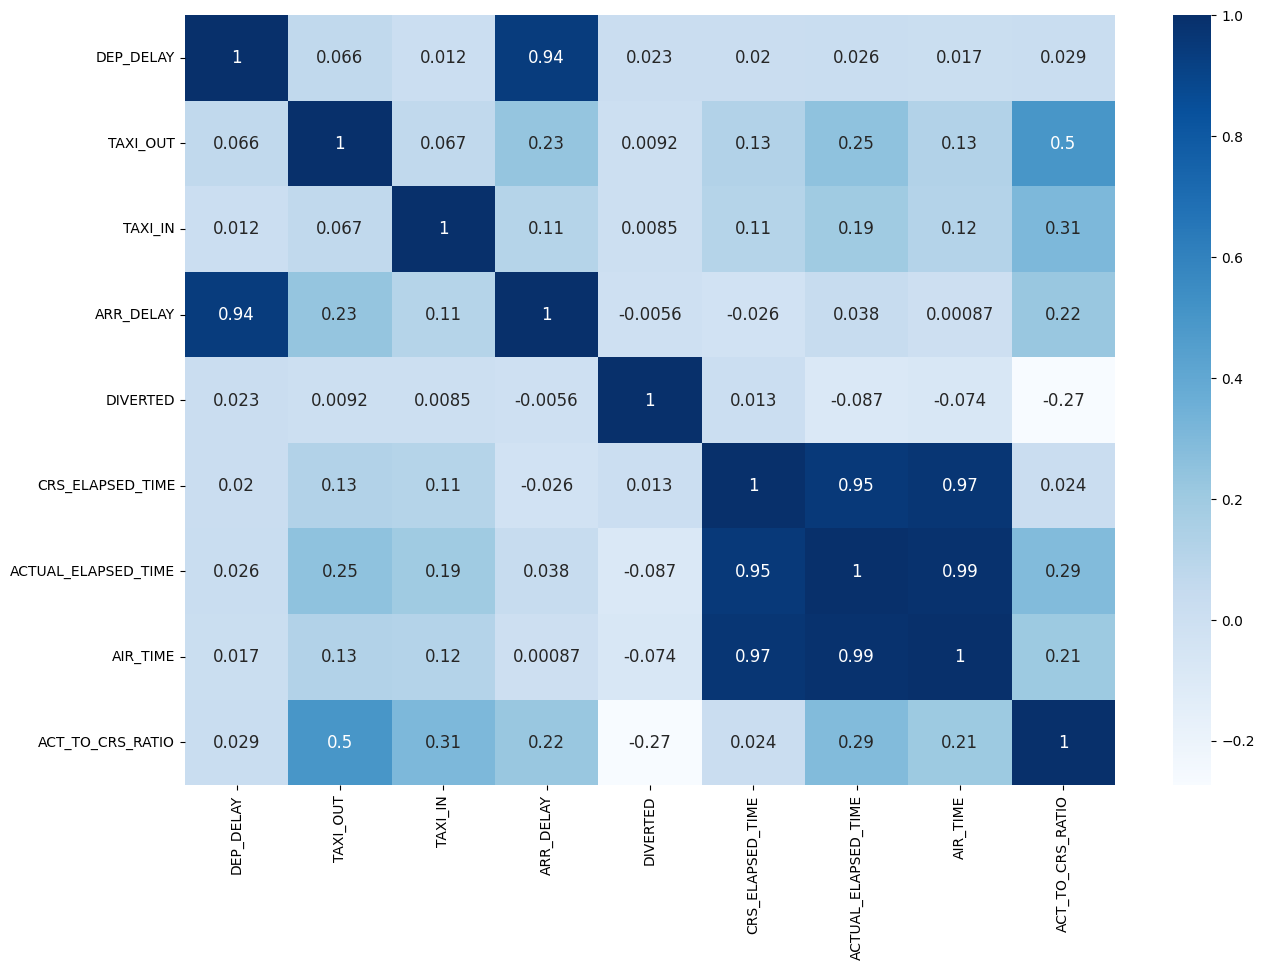

In [38]:
# Visualizzazione della heatmap per il sottoinsieme rimanente, con una dimensione personalizzata della figura
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df.drop(['CANCELLED'], axis=1).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})  # Mostra la heatmap con annotazioni
plt.show()


In [39]:
df = df.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DEP_DELAY'], axis=1)

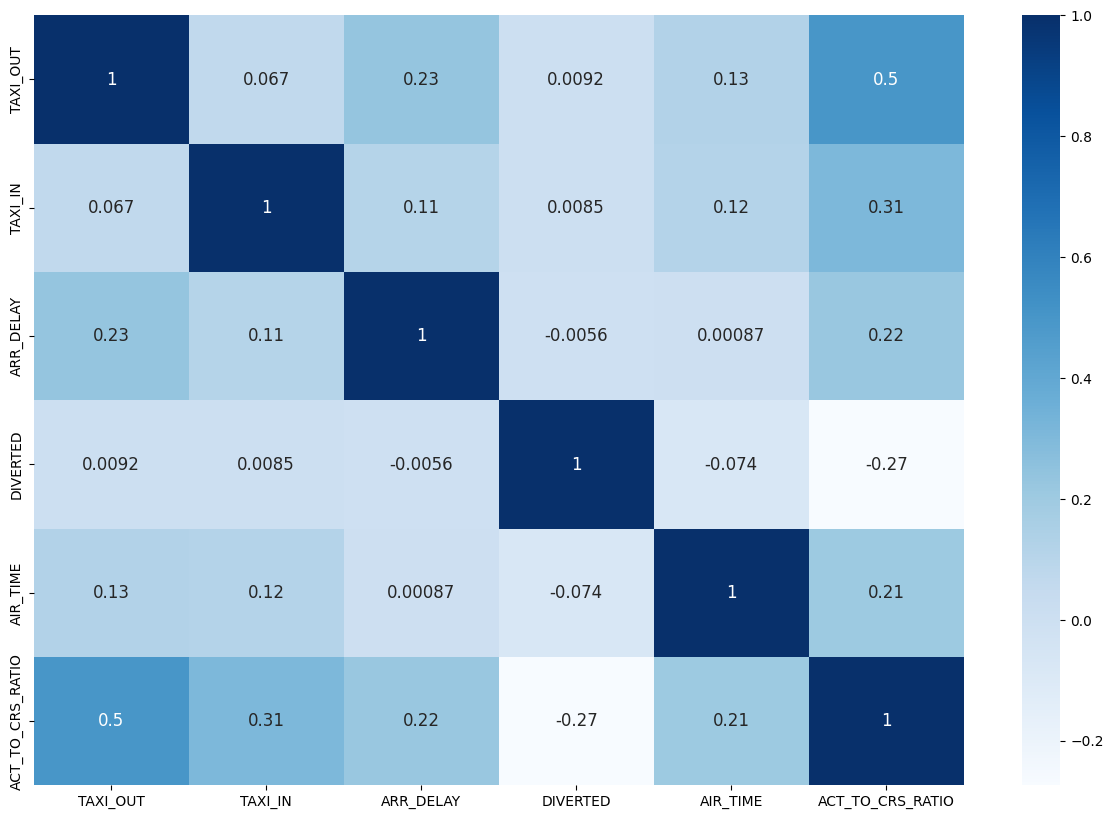

In [40]:
# Visualizzazione della heatmap per il sottoinsieme rimanente, con una dimensione personalizzata della figura
plt.figure(figsize=(15, 10))
ax = sns.heatmap(df.drop(['CANCELLED'], axis=1).corr(), cmap="Blues", annot=True, annot_kws={"size": 12})  # Mostra la heatmap con annotazioni
plt.show()


# Classificazione

In [41]:
y = df['CANCELLED']
x = df.drop(columns=['CANCELLED'])


# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(95416, 6)
(23855, 6)
(95416,)
(23855,)


## Bilanciamento

In [42]:
# Crea una strategia di undersampling personalizzata
undersampler = RandomUnderSampler(
    sampling_strategy={0: y_train[y_train == 1].shape[0], 1: y_train[y_train == 1].shape[0]}, 
    random_state=42
)

# Applica l'undersampling al set di addestramento
x_train, y_train = undersampler.fit_resample(x_train, y_train)

# Controlla la distribuzione delle classi dopo l'undersampling
print(y_train.value_counts())


CANCELLED
0.0    1548
1.0    1548
Name: count, dtype: int64


## Training

In [43]:
classifiers = [
    LogisticRegression(random_state=rs),
    DecisionTreeClassifier(random_state=rs),
    RandomForestClassifier(n_estimators=10, random_state=rs),
    GradientBoostingClassifier(random_state=rs),
    GaussianNB(),  # Aggiunto Bayes
    LinearDiscriminantAnalysis(),
    SVC(probability=True),
    XGBClassifier(random_state=rs)  # Aggiunto XGBoost
]


# List of results that will occur:
clf_name = []  # names of the classifiers
model_results = pd.DataFrame(y_test.copy())

kfold = StratifiedKFold(n_splits=5)  # cross-validation
cv_results = []  # scores from cross-validation
cv_acc = []  # mean accuracy from cross-validation, need to maximize
cv_std = []  # standard deviation from cross-validation, need to minimize

cnfm = []  # confusion matrix
clr = []  # classification report
roc_auc = []  # roc curve
roc_tpr = []
roc_fpr = []

In [44]:
class_weights = {i: 1 for i in range(len(y_train.unique()))}  # Default weight of 1 for all classes

# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)

    # Apply class weights during training if the classifier supports it
    if hasattr(clf, 'class_weight'):
        clf.set_params(class_weight=class_weights)  # Set custom class weights

    # Fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred.tolist()

    # Accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring="accuracy", cv=kfold))
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2)  # Need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name}')

    # Confusion matrix, classification report, ROC curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)

# Calculate cross-validation results
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 1.0 	 ---> LogisticRegression
Accuracy: 1.0 	 ---> DecisionTreeClassifier
Accuracy: 1.0 	 ---> RandomForestClassifier
Accuracy: 1.0 	 ---> GradientBoostingClassifier
Accuracy: 1.0 	 ---> GaussianNB
Accuracy: 1.0 	 ---> LinearDiscriminantAnalysis
Accuracy: 1.0 	 ---> SVC
Accuracy: 1.0 	 ---> XGBClassifier


C:\Users\dswal\AppData\Local\Temp\ipykernel_16388\468612739.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


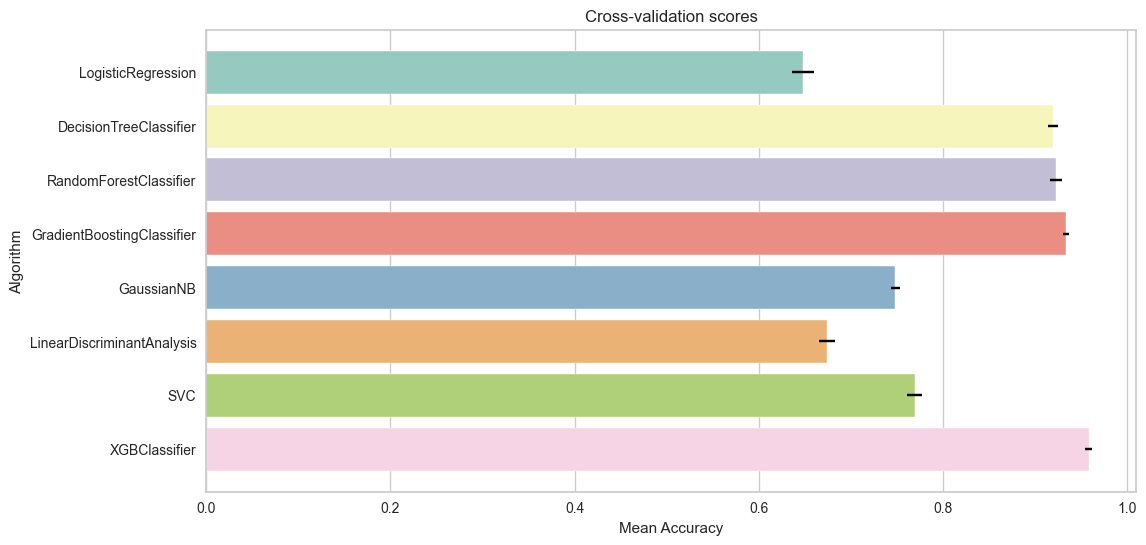

In [94]:
# Ensure consistency
cv_res = pd.DataFrame({"CrossValMeans": cv_acc, "CrossValerrors": cv_std, "Algorithm": clf_name})

# Plot
plt.figure(figsize=(12, 6))

# Barplot senza barre di errore
sns.barplot(
    x="CrossValMeans", y="Algorithm", data=cv_res,
    palette="Set3", orient="h"
)

# Aggiungi barre di errore manualmente
for index, row in cv_res.iterrows():
    plt.errorbar(
        x=row["CrossValMeans"], y=index, xerr=row["CrossValerrors"], fmt='none', c='black', capsize=5
    )

plt.xlabel("Mean Accuracy")
plt.title("Cross-validation scores")
plt.show()

In [95]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
cv_res.head()

,CrossValMeans,CrossValerrors,Algorithm
0,0.648105,0.012028,LogisticRegression
1,0.919579,0.005874,DecisionTreeClassifier
2,0.922842,0.006931,RandomForestClassifier
3,0.934105,0.003130,GradientBoostingClassifier
4,0.748421,0.005200,GaussianNB


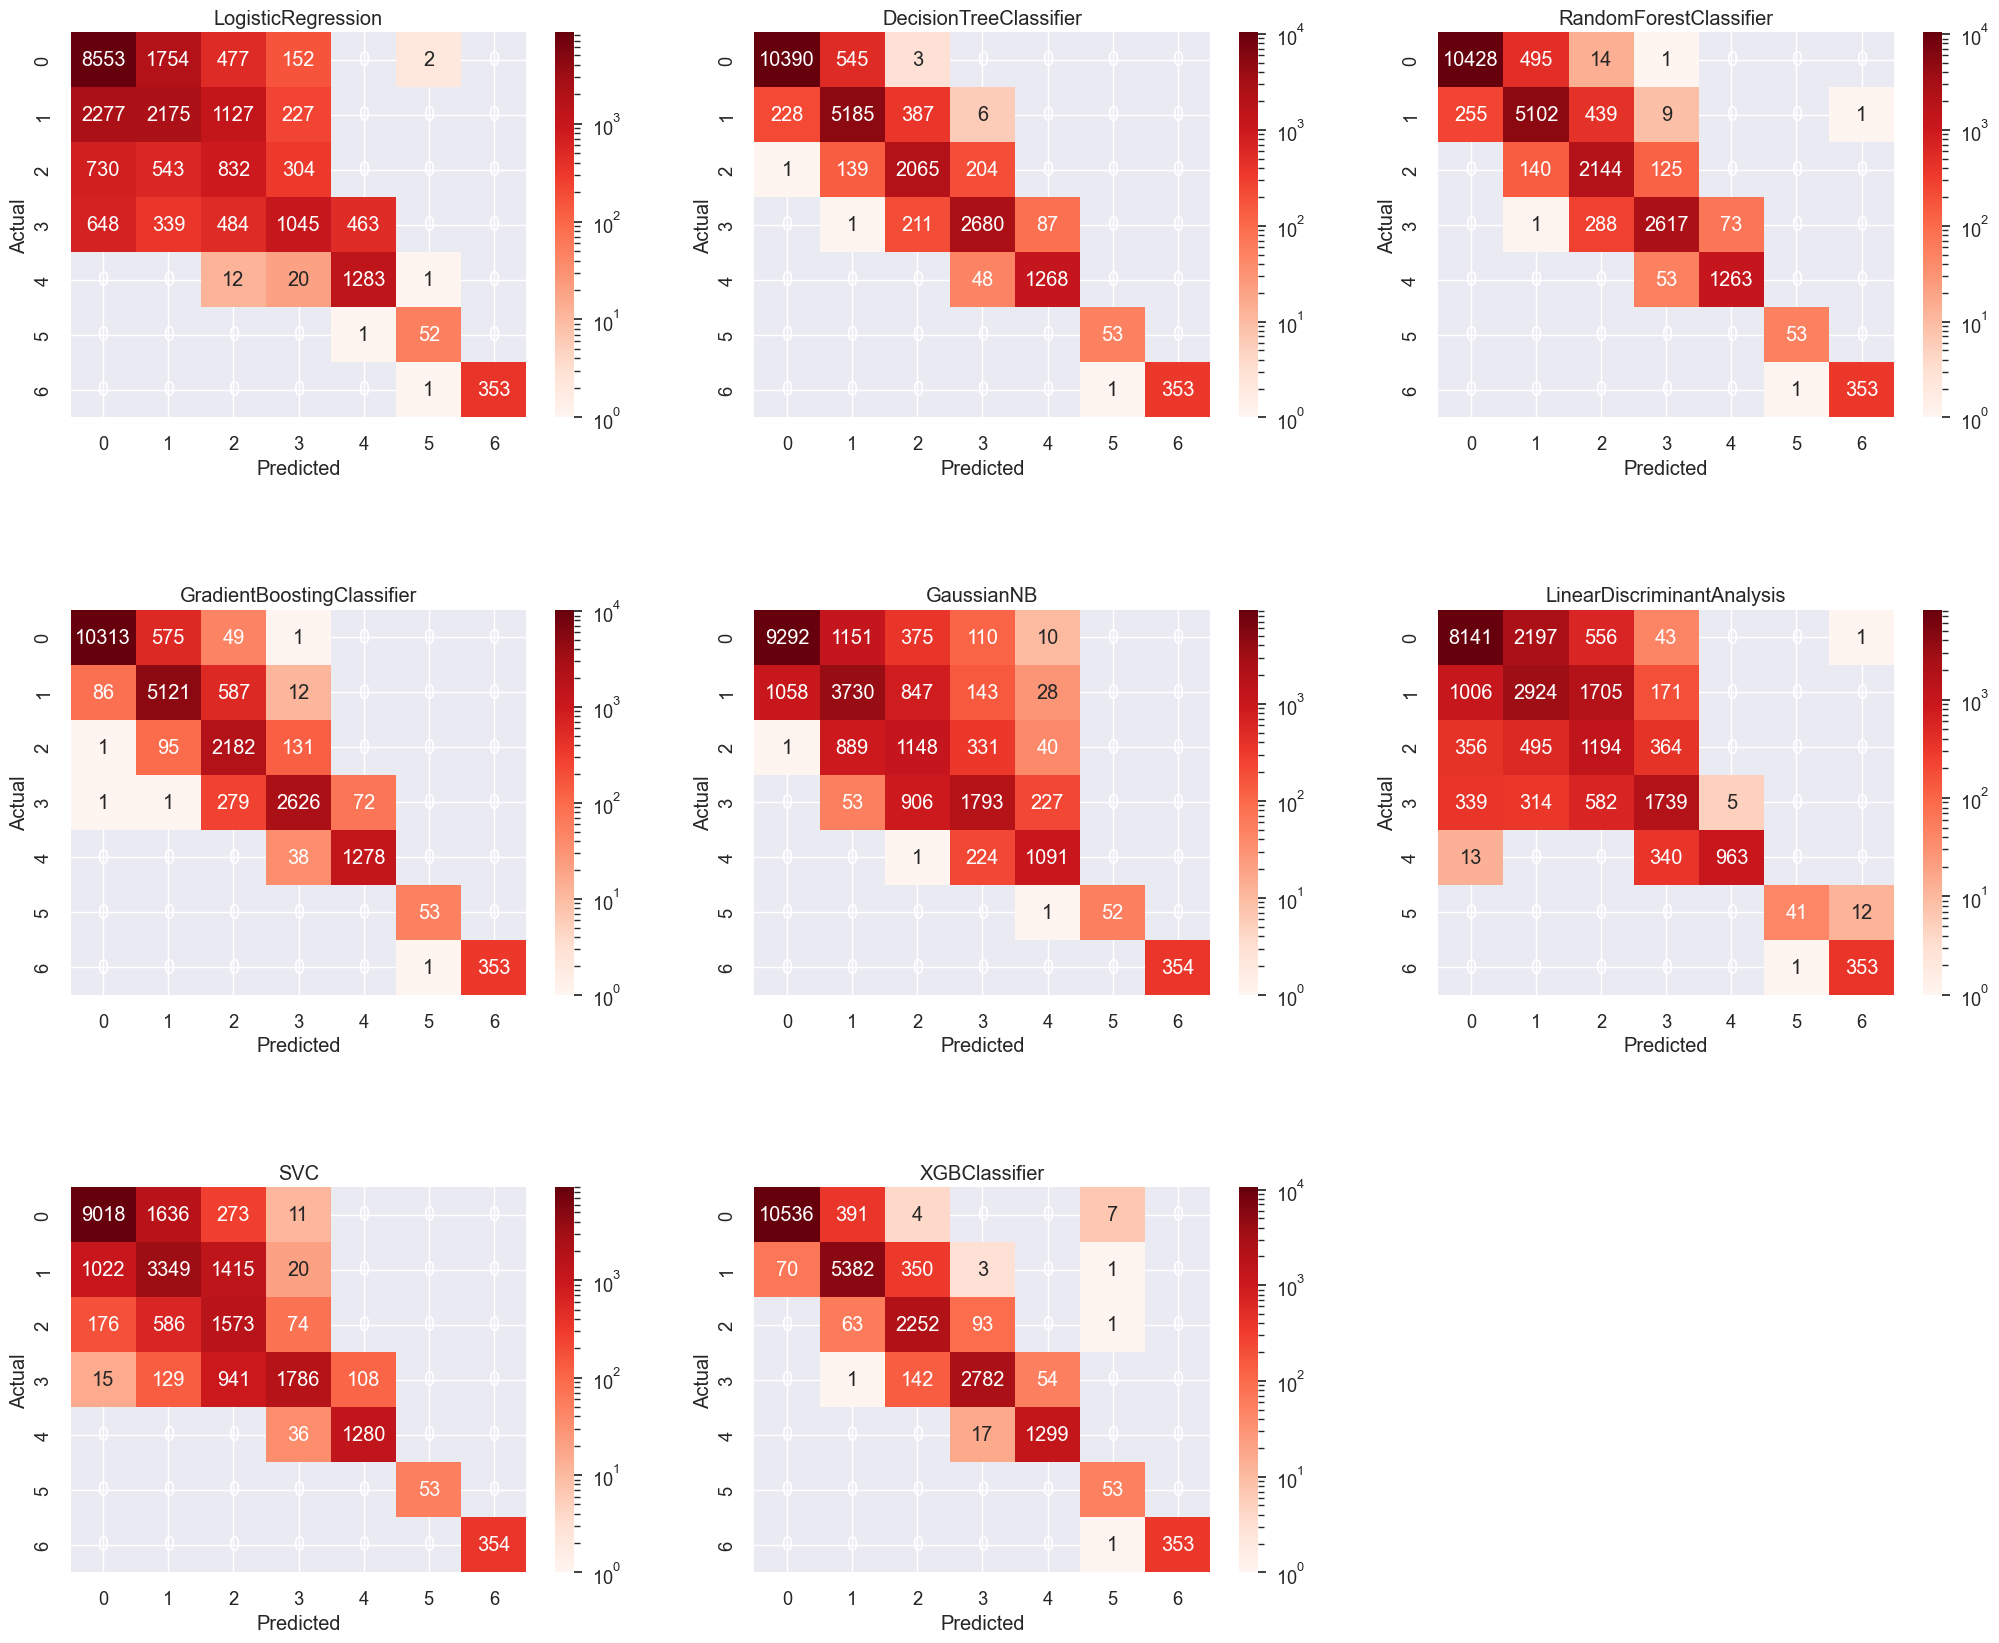

In [96]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,20))
sns.set(font_scale=1.2)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1)  # Adjust this according to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d", cmap="Reds", 
                norm=LogNorm(vmin=1, vmax=cnfm[i].max()))  # Emphasize lower values
    plt.subplots_adjust(hspace=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])


In [97]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     10938
           1       0.45      0.37      0.41      5806
           2       0.28      0.35      0.31      2409
           3       0.60      0.35      0.44      2979
           4       0.73      0.97      0.84      1316
           5       0.93      0.98      0.95        53
           6       1.00      1.00      1.00       354

    accuracy                           0.60     23855
   macro avg       0.67      0.69      0.67     23855
weighted avg       0.59      0.60      0.59     23855

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10938
           1       0.88      0.89      0.89      5806
           2       0.77      0.86      0.81      2409
           3       0.91      0.90      0.91      2979
           4       0.94      0.96      0.95 

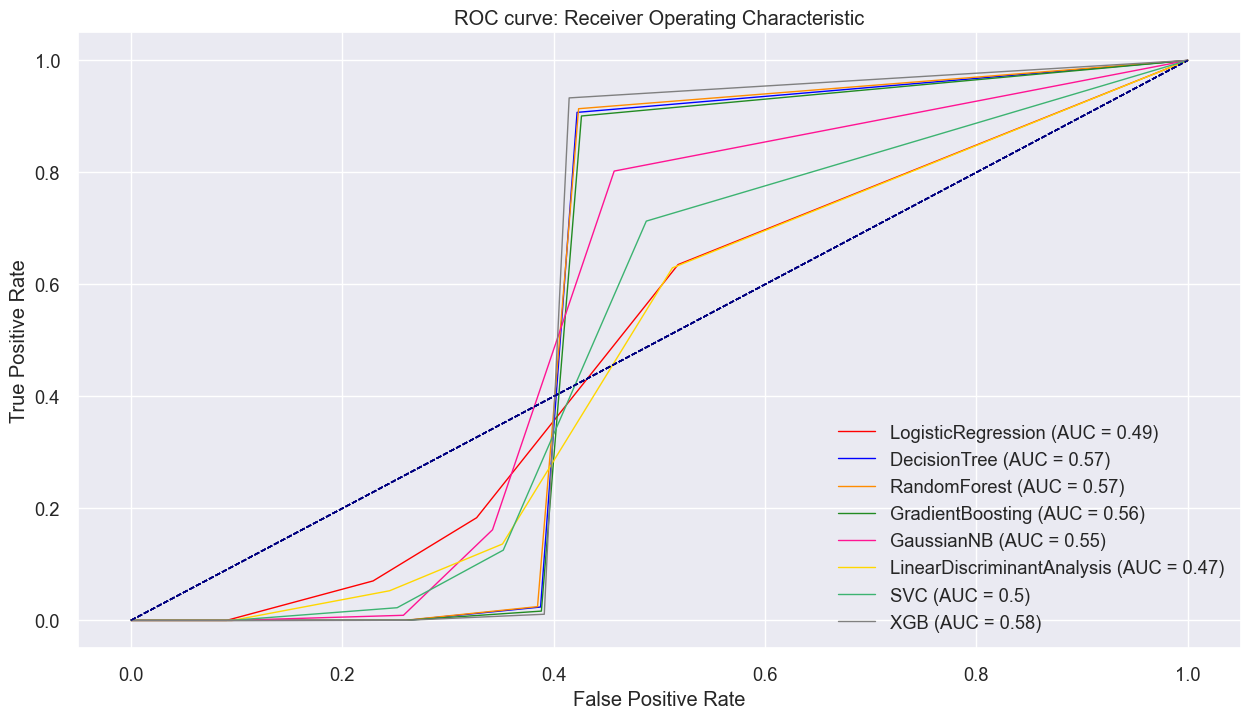

In [ ]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'darkorange', 'forestgreen', 'deeppink', 'gold', 'mediumseagreen', 'gray', 'brown', 'deepskyblue','cyan']  # Improved color selection
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")


Text(0.5, 1.0, 'Correlation between models')

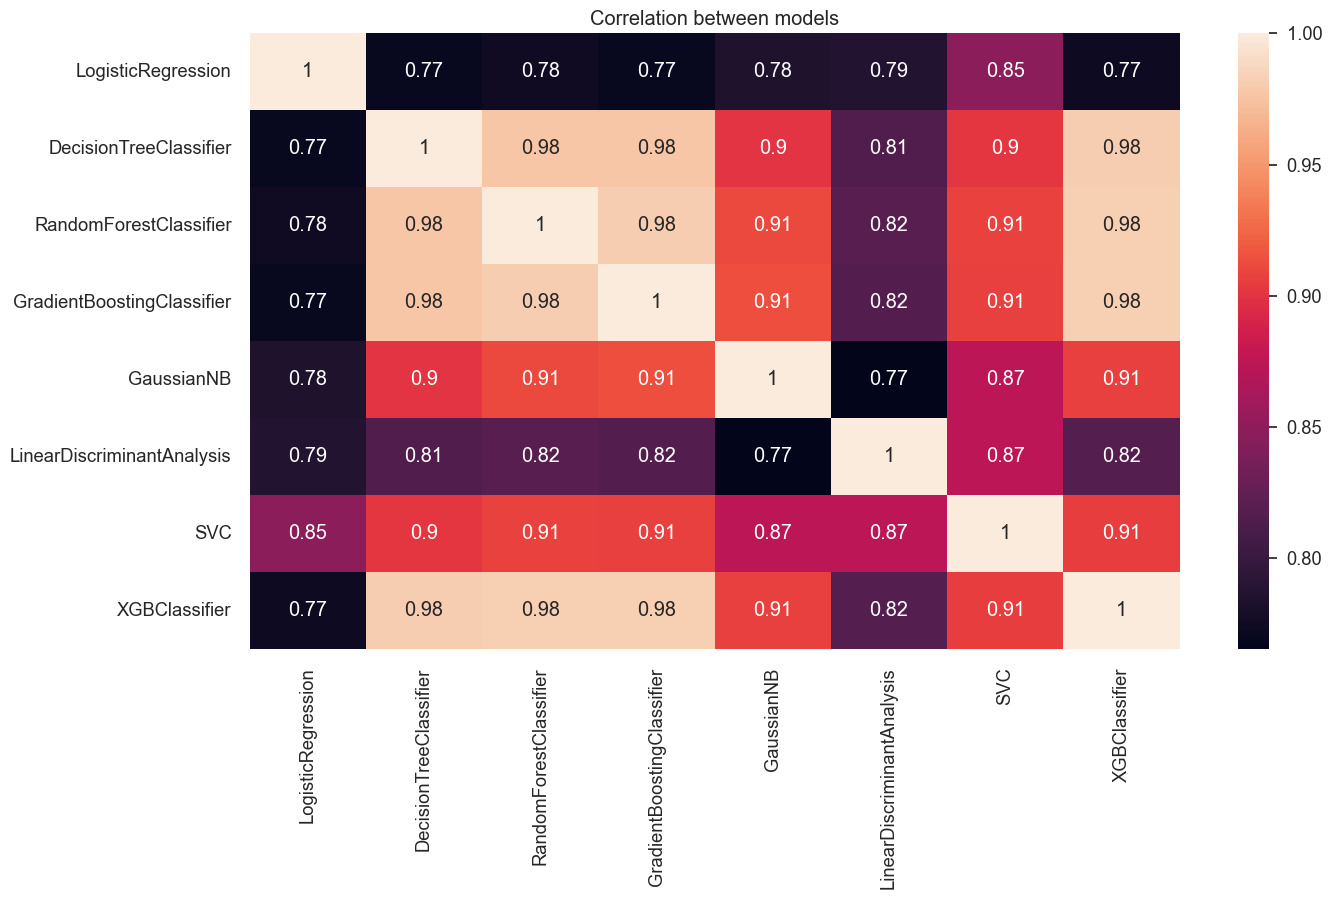

In [99]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop('FLIGHT_STATUS', axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [ ]:
# Parametri per XGBClassifier
XGB_param = {
    "learning_rate": [0.01, 0.1, 0.3],  # Tasso di apprendimento
    "n_estimators": [50, 100, 200],  # Numero di alberi
    "max_depth": [3, 6, 9],  # Profondità massima degli alberi
    "subsample": [0.8, 0.9, 1.0],  # Fractions of samples to use per tree
    "colsample_bytree": [0.8, 0.9, 1.0],  # Fractions of features to use per tree
    "gamma": [0, 0.1, 0.2],  # Penalizzazione sulla profondità dell'albero
    "reg_alpha": [0, 0.1, 1],  # Regularization L1
    "reg_lambda": [0, 0.1, 1]  # Regularization L2
}

# Parametri per LogisticRegression
LR_param = {
    "penalty": ["l2", "none"],  # Tipo di penalizzazione
    "C": [0.1, 1, 10],  # Parametro di regolarizzazione
    "solver": ["liblinear", "saga"],  # Algoritmi per ottimizzazione
    "max_iter": [100, 200, 300]  # Iterazioni massime
}

# Creazione dei modelli
XGBgs = GridSearchCV(
    XGBClassifier(), param_grid=XGB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1
)
LRgs = GridSearchCV(
    LogisticRegression(), param_grid=LR_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose=1
)

# Aggiunta dei modelli alla lista
models = [XGBgs, LRgs]

gs_model = []
score = []

# Ciclo per addestrare e registrare i risultati
for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)


Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


In [ ]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.92 0.934
score with GridSearchCV:  0.874 0.947


# Model Ensamble

In [ ]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

0.9219031649549361


# Testing

In [ ]:
# Load the test data
flights_test = pd.read_csv("dataset/test_flights.csv")

flights_test = ETL(flights_test)

# Variabili da standardizzare (con possibili outliers)
standard_features = [
    'DEP_DELAY', 'ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 
    'ACT_TO_CRS_RATIO', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
    'AIR_TIME', 'DISTANCE'
]

min_max_scaler = MinMaxScaler()

# Standardizzazione delle variabili con outliers
flights_test[standard_features] = min_max_scaler.fit_transform(flights_test[standard_features])

drop_features = [
    'CRS_DEP_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
    'CRS_DEP_TIME', 'FL_YEAR', 'DEP_TIME', 
    'ARR_TIME','WHEELS_OFF', 'WHEELS_ON',
    'ORIGIN', 'DEST', 'OP_CARRIER',
    'FL_MON',	'FL_DAY',	'FL_DOW', 'CANCELLED'
]


flights_test = flights_test.drop(columns=drop_features, errors='ignore')

flights_test = flights_test.drop(columns='OP_CARRIER_FL_NUM', errors='ignore')

# Create dummies - for better model outcomes
flights_test = pd.get_dummies(flights_test)

# Aggiungi la colonna 'C_REASON_Security' nella penultima posizione
flights_test.insert(len(flights_test.columns)-1, 'C_REASON_Security', 0)

# Replace NaNs with a placeholder category
flights_test.fillna(False, inplace=True)

flights_test = flights_test.drop(['CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'C_REASON_Not cancelled', 'DEP_DELAY'], axis=1)


In [ ]:
#train the model on the whole dataset and produce results:
cancelled_pred = pd.Series(best_model.predict(flights_test), name='CANCELLED')

In [ ]:
cancelled_pred.value_counts()

FLIGHT STATUS
3    46685
2     4897
1     3731
4     1929
6      936
0      314
5      165
Name: count, dtype: int64

# Yellowbrick

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

In [ ]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["non_cancellato", "cancellato"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

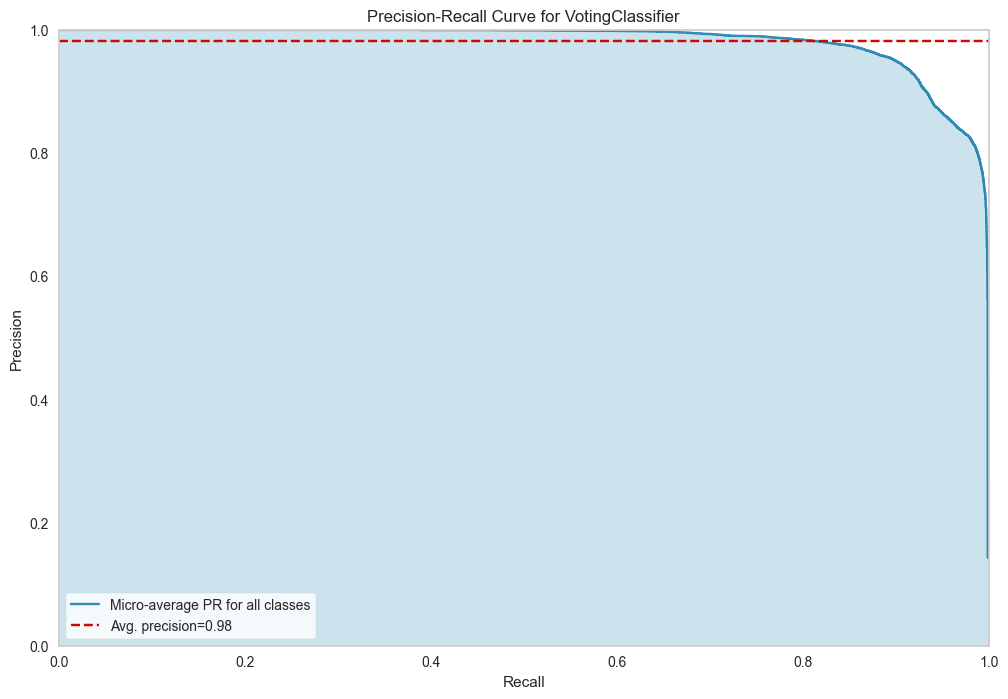

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

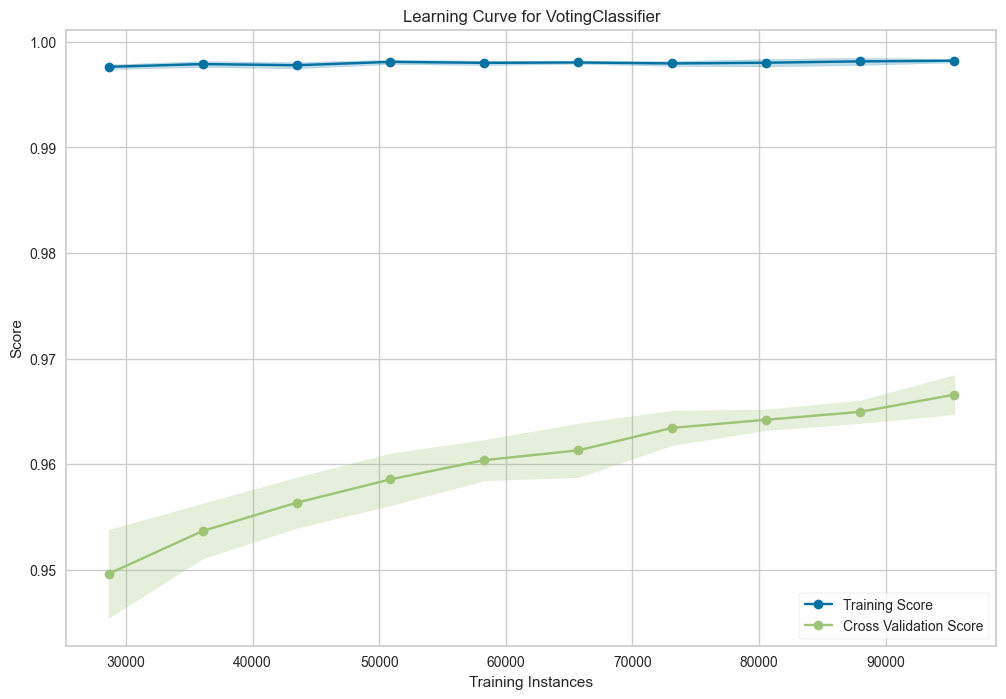

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure